In [54]:
import os
import random
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageColor
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.metropolis_hastings import metropolis_hastings, binomial_distribution, propose_state, probability_matrix

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")

OUT_PATH = os.path.join(DATASET_PATH, "unet")
OUT_TRAIN_PATH_X = os.path.join(OUT_PATH, "train", "x")
OUT_TRAIN_PATH_Y = os.path.join(OUT_PATH, "train", "y")
OUT_TEST_PATH_X = os.path.join(OUT_PATH, "test", "x")
OUT_TEST_PATH_Y = os.path.join(OUT_PATH, "test", "y")

In [ ]:
def getSystemParams(systems, idx, eps=0):
    
    sys = systems[idx]
    x0 = max(0, sys["x"] - eps)
    y0 = max(0, sys["y"] - eps)
    x1 = x0 + sys["width"] + 2 * eps
    y1 = y0 + sys["height"] + 2 * eps
    factor = 256 / (sys["height"] + 2 * eps)
    
    def map_box_coords(x, y, w, h):
        x = int((x - x0) * factor)
        y = int((y - y0) * factor)
        w = int(w * factor)
        h = int(h * factor)
        return x, y, w, h
    
    def map_img(img):
        crop = img[y0:y1, x0:x1].astype(np.uint8)
        res = cv2.resize(crop, (int((x1 - x0) * factor), 256))
        return res
        
    return map_box_coords, map_img

In [61]:
out_idx = 1

# make output directories
os.makedirs(OUT_TRAIN_PATH_X, exist_ok=True)
os.makedirs(OUT_TRAIN_PATH_Y, exist_ok=True)
os.makedirs(OUT_TEST_PATH_X, exist_ok=True)
os.makedirs(OUT_TEST_PATH_Y, exist_ok=True)

for s_idx in tqdm(range(1, 26)):
    sample_idx = f"{s_idx:03d}"

    # for each sample:
    imgs = [cv2.imread(os.path.join(PNG_PATH, sample_idx, f"out-{i}.png")) for i in range(51)]
    bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=imgs[0].shape)

    systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
    unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))

    for idx, type in enumerate(unique_types):
        
        # get all bboxes of current type
        tbs = [bbox for bbox in bboxes if bbox["type"] == type]
        if len(tbs)==0:
            print("no box found for:", type)
            continue
        
        # pick random bbox
        rand_idx = random.randint(0, len(tbs) - 1)
        bbox = tbs[rand_idx]
        cx = bbox["cx"]
        cy = bbox["cy"]
        w = bbox["width"]
        h = bbox["height"]
        
        # map to system coordinates
        map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
        cx, cy, w, h = map_box_coords(cx, cy, w, h)
        img_x = map_img(imgs[0])
        
        # get frame centered around bbox center
        x0 = cx - 128
        x1 = cx + 128
        if x0 < 0:
            x0 = 0
            x1 = 256
        if x1 > img_x.shape[1]:
            x1 = img_x.shape[1]
            x0 = x1 - 256
            
        # split into train and test data
        if s_idx < 20:
            out_path_x = OUT_TRAIN_PATH_X
            out_path_y = OUT_TRAIN_PATH_Y
        else:
            out_path_x = OUT_TEST_PATH_X
            out_path_y = OUT_TEST_PATH_Y
        if s_idx == 20:
            out_idx = 1
        
        # crop and save x
        img_x = img_x[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_x, f"{out_idx:03d}.png"), img_x)
        
        # crop and save y
        img_y = map_img(imgs[1])[:, x0:x1]
        cv2.imwrite(os.path.join(out_path_y, f"{out_idx:03d}.png"), img_y)
        
        img_y_multi = np.zeros((256, 256, 48), dtype=bool)
        for i in range(3, 51):
            img_y_multi[..., i-3] = np.any(map_img(imgs[i])[:, x0:x1] > 0, axis=2)
        np.save(os.path.join(out_path_y, f"{out_idx:03d}.npy"), img_y_multi)
        
        out_idx += 1

  0%|          | 0/25 [00:06<?, ?it/s]


IndexError: index 47 is out of bounds for axis 2 with size 47

1777 1869
772 121 AccidentalNatural
1828 1764
795 74 Flag8thUp
1214 1138
396 110 DynamicCrescendoHairpin
454 925
138 38 AccidentalDoubleFlat
506 2002
206 180 Flag16thUp
1113 1358
361 185 NoteheadHalf
1898 1753
826 69 AccidentalDoubleSharp
740 1779
310 81 Flag8thDown
730 1771
305 77 Stem
315 1742
fix
120 64 KeySharp
194 2300
fix
56 47 TimeSig4
1593 881
524 23 NoteheadBlack
1218 2666
438 184 RestWhole
2032 1383
fix2
673 193 Flag64thUp
455 2541
153 137 DynamicM
1823 2541
664 137 DynamicF
2263 1730
fix2
989 59 BarLineThick
491 2548
167 140 DynamicP
1699 264
592 60 AccidentalSharp
118 1727
fix
33 57 ClefG
119 613
fix
26 185 ClefF
1199 987
391 59 Flag16thDown
1953 2080
851 215 Flag32ndUp
2109 579
fix2
739 172 NoteheadWhole
57 2502
fix
4 123 Brace
1251 965
408 52 Rest32nd
814 557
275 165 Slur
1701 440
593 123 DynamicDiminuendoHairpin
407 625
129 189 TimeSigCommon
1984 2239
fix2
725 25 AccidentalFlat
1733 1727
753 57 RestQuarter
1931 229
fix2
675 47 AugmentationDot
1171 625
403 189 Staff
1563 

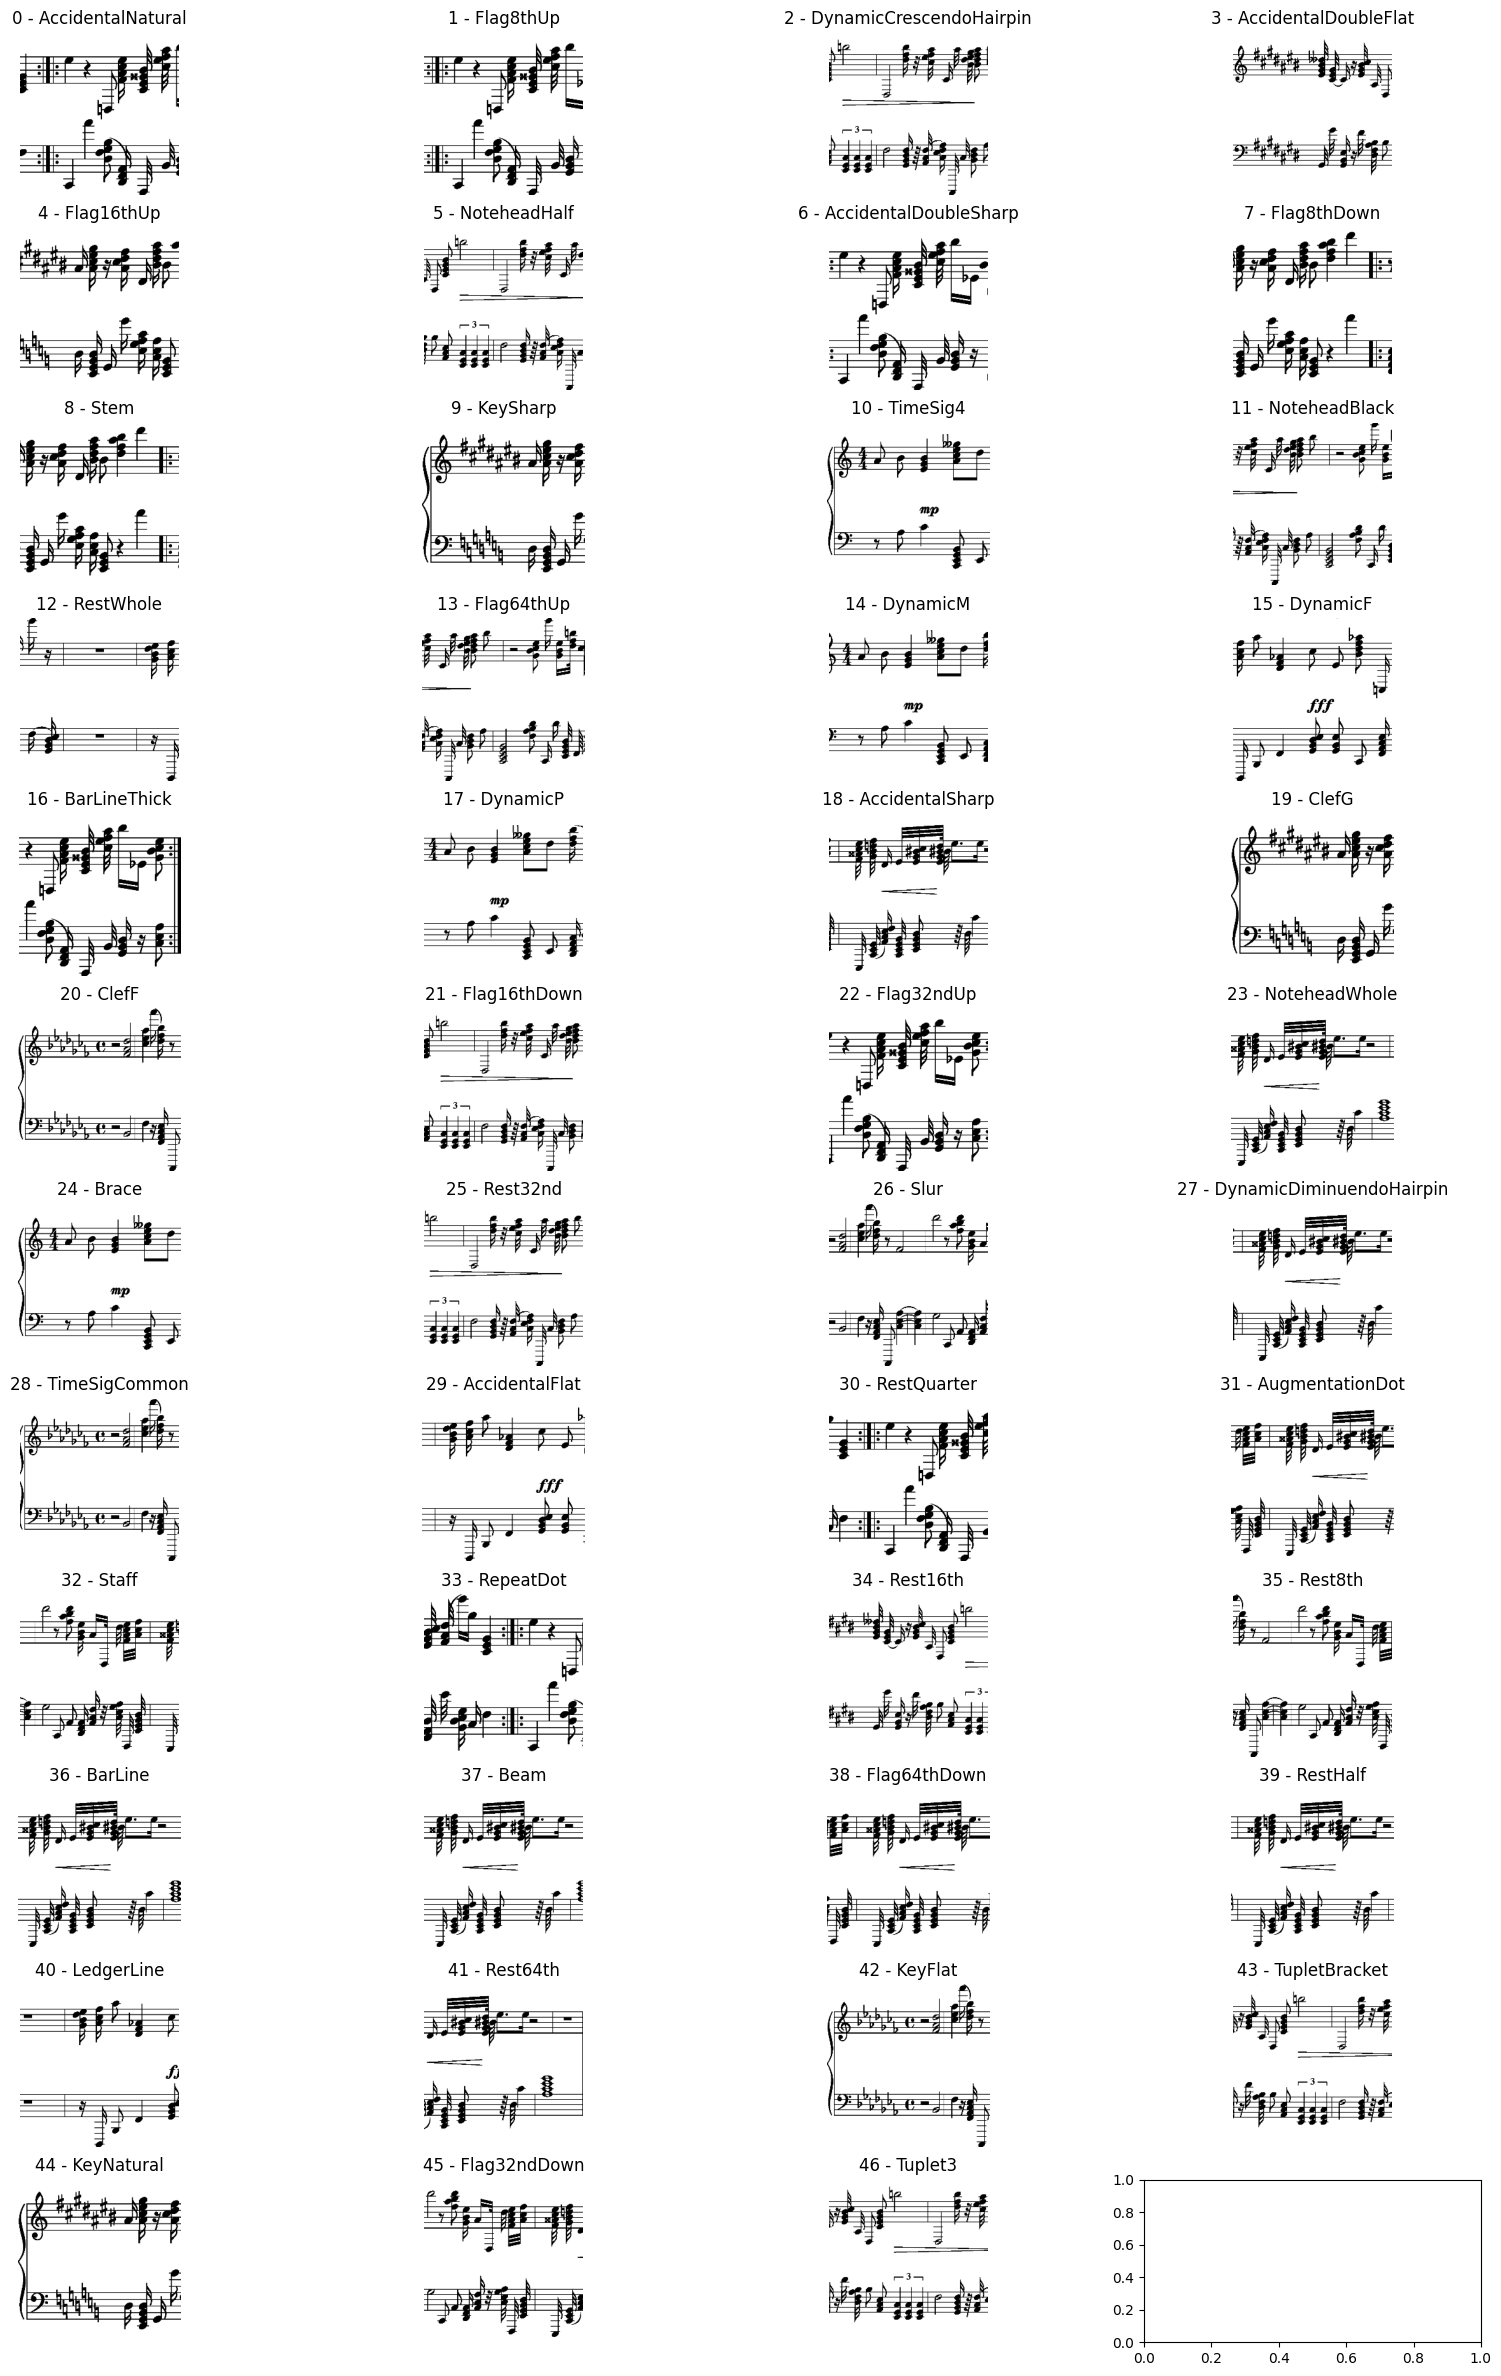

In [31]:
random.seed(41)
len(unique_types)

fig, axs = plt.subplots(12, 4, figsize=(20, 30))
axs = axs.reshape(-1)

for idx, type in enumerate(unique_types):
    tbs = [bbox for bbox in bboxes if bbox["type"] == type]
    if len(tbs)==0:
        print("no box found for:", type)
        continue
    rand_idx = random.randint(0, len(tbs) - 1)
    
    bbox = tbs[rand_idx]
    cx = bbox["cx"]
    cy = bbox["cy"]
    w = bbox["width"]
    h = bbox["height"]
    print(cx, cy)
    
    
    map_box_coords, map_img = getSystemParams(systems, int(bbox["systemId"]))
    cx, cy, w, h = map_box_coords(cx, cy, w, h)
    img_x = map_img(img)#[:, x0: x1]
    
    x0 = cx - 125
    x1 = cx + 125
    if x0 < 0:
        x0 = 0
        x1 = 256
        print("fix")
    if x1 > img_x.shape[1]:
        x1 = cx + w
        x0 = x1 - 256
        print("fix2")
    # img_x = cv2.rectangle(img_x, (x0, 0), (x1, img_x.shape[0]), (255, 0, 0), 4)
    axs[idx].imshow(img_x[:, x0:x1])
    axs[idx].set_title(f"{idx} - {type}")
    axs[idx].axis('off')
    print(cx, cy, type)

['AccidentalNatural', 'Flag8thUp', 'DynamicCrescendoHairpin', 'AccidentalDoubleFlat', 'Flag16thUp', 'NoteheadHalf', 'AccidentalDoubleSharp', 'Flag8thDown', 'Stem', 'KeySharp', 'TimeSig4', 'NoteheadBlack', 'RestWhole', 'Flag64thUp', 'DynamicM', 'DynamicF', 'BarLineThick', 'DynamicP', 'AccidentalSharp', 'ClefG', 'ClefF', 'Flag16thDown', 'Flag32ndUp', 'NoteheadWhole', 'Brace', 'Rest32nd', 'Slur', 'DynamicDiminuendoHairpin', 'TimeSigCommon', 'AccidentalFlat', 'RestQuarter', 'AugmentationDot', 'Staff', 'RepeatDot', 'Rest16th', 'Rest8th', 'BarLine', 'Beam', 'Flag64thDown', 'RestHalf', 'LedgerLine', 'Rest64th', 'KeyFlat', 'TupletBracket', 'KeyNatural', 'Flag32ndDown', 'Tuplet3']


47